In [115]:
import tensorflow as tf 
import os

In [116]:
# Setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

### Removing Dodgy Images

In [118]:
import cv2
import imghdr

In [119]:
data_dir = 'data'

In [120]:
image_exts = ['jpeg','jpg','bmp','png']

In [121]:
image_exts[2]

'bmp'

In [122]:
os.listdir(data_dir)

['happy', 'sad']

In [123]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

### Loading Data

In [125]:
import numpy as np
from matplotlib import pyplot as plt

In [126]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 173 files belonging to 2 classes.


In [127]:
data_iterator = data.as_numpy_iterator()

In [128]:
batch = data_iterator.next()

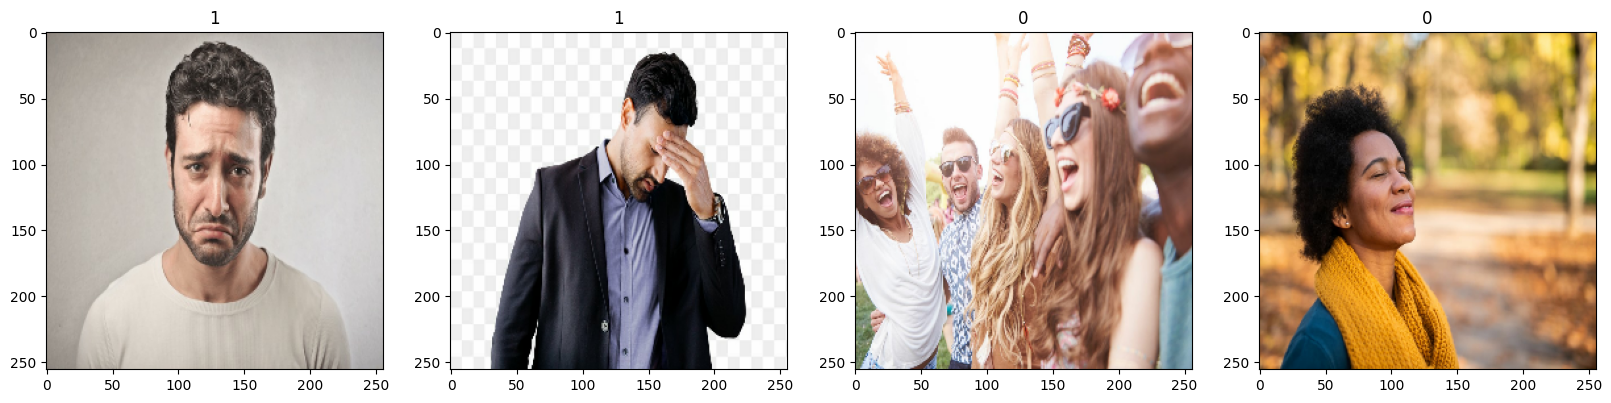

In [129]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

### Preprocessing Data

In [131]:
# Scaling the Data
scaled = data.map(lambda x,y: (x/255, y))

In [132]:
scaled_iterator = data.as_numpy_iterator()

In [133]:
batch = scaled_iterator.next()

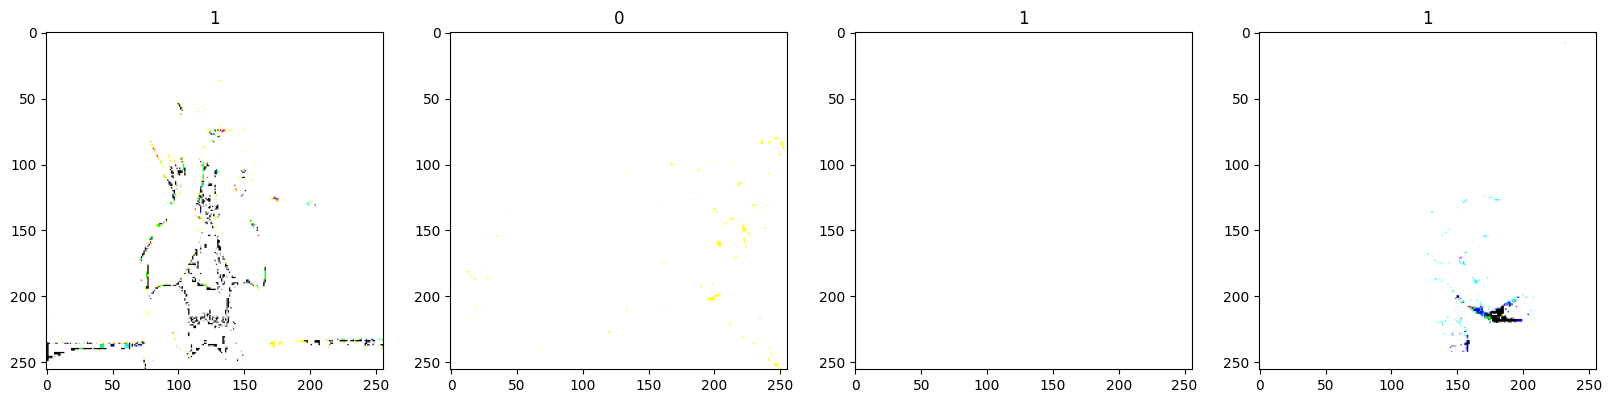

In [134]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

In [135]:
# Splitting Data
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)+1
test_size = int(len(data)*.1)+1

In [136]:
train_size

4

In [137]:
val_size

2

In [138]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [139]:
len(val)

2

### Building the Deep Learning Model

In [141]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [142]:
model = Sequential()

In [143]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [144]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [145]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 254, 254, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 127, 127, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 125, 125, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 60, 60, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 30, 30, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 14400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       3,686,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

### Train

In [147]:
logdir='logs'

In [148]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [149]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 333ms/step - accuracy: 0.5448 - loss: 236.7871 - val_accuracy: 0.5111 - val_loss: 105.7069
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 292ms/step - accuracy: 0.4583 - loss: 93.5065 - val_accuracy: 0.6000 - val_loss: 5.2001
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 269ms/step - accuracy: 0.6500 - loss: 6.1376 - val_accuracy: 0.8222 - val_loss: 0.3868
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 274ms/step - accuracy: 0.8323 - loss: 0.3777 - val_accuracy: 0.8889 - val_loss: 0.2260
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 305ms/step - accuracy: 0.9344 - loss: 0.1820 - val_accuracy: 0.9778 - val_loss: 0.1057
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 280ms/step - accuracy: 0.9219 - loss: 0.1448 - val_accuracy: 0.9778 - val_loss: 0.0799
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 285ms/step - accuracy: 0.9677 - loss: 0.0865 - val_accuracy: 1.0000 - val_loss: 0.0453
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 274ms/step - accuracy: 0.9604 - loss: 0.0778 - val_accuracy: 1.0000 - val_

### Plot Performance

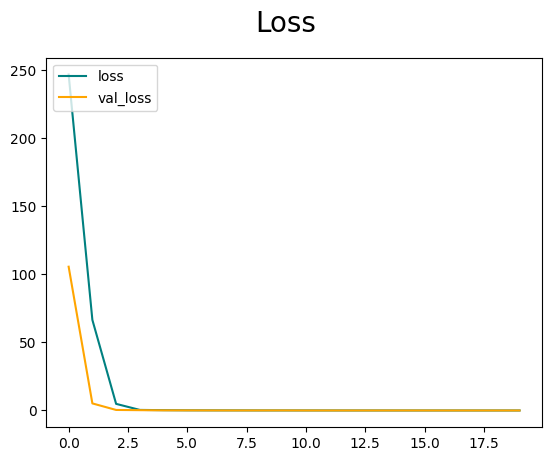

In [151]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

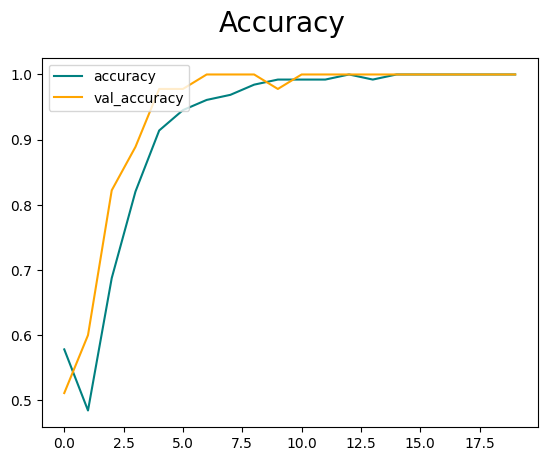

In [152]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

### Evaluation

In [154]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [155]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [156]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

In [157]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32)


### Test

In [159]:
import cv2

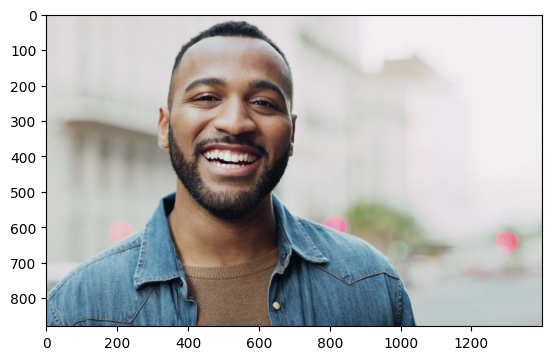

In [160]:
imghappy = cv2.imread('happytest.jpg')
plt.imshow(cv2.cvtColor(imghappy, cv2.COLOR_BGR2RGB))
plt.show()

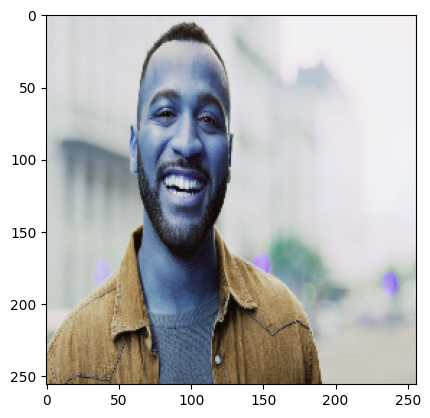

In [161]:
resizehappy = tf.image.resize(imghappy, (256,256))
plt.imshow(resizehappy.numpy().astype(int))
plt.show()

In [162]:
yhat = model.predict(np.expand_dims(resizehappy/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


In [163]:
yhat

array([[0.49287784]], dtype=float32)

In [164]:
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Happy


### Sad Test

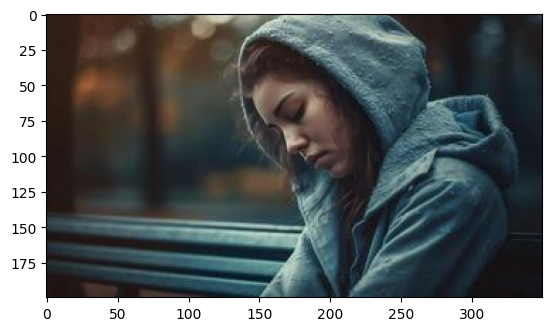

In [166]:
imgsad = cv2.imread('sadtest.jpg')
plt.imshow(cv2.cvtColor(imgsad, cv2.COLOR_BGR2RGB))
plt.show()

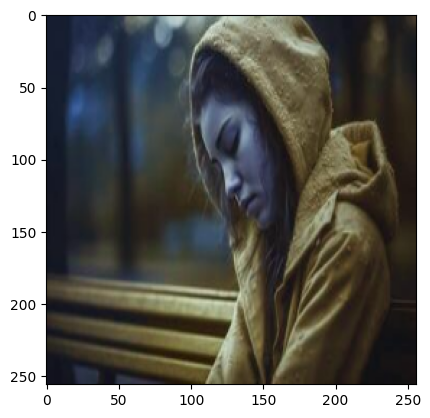

In [167]:
resizesad = tf.image.resize(imgsad, (256,256))
plt.imshow(resizesad.numpy().astype(int))
plt.show()

In [168]:
yhat = model.predict(np.expand_dims(resizesad/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


In [169]:
yhat

array([[0.519881]], dtype=float32)

In [170]:
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Sad


### Saving the Model

In [172]:
from tensorflow.keras.models import load_model

In [173]:
model.save(os.path.join('models','imageclassifier.h5'))

In [174]:
new_model = load_model(os.path.join('models','imageclassifier.h5'))

In [175]:
yhatnew = new_model.predict(np.expand_dims(resizehappy/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


In [176]:
if yhatnew > 0.5:
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Happy
